# SOFIA/FORCAST Galactic Center Photometry Notebook

## Preliminary Steps - Select file to use from config.py and load in required packages

In [1]:
#uncomment this to see the names of the different configurations that can be loaded in
from config import *

fieldlist=[]
for info in field._registry:
    fieldlist.append(info.name)
print('Names of available configurations for fields:, ', fieldlist)

mosaiclist=[]
for info in mosaic._registry:
    mosaiclist.append(info.name)
print('\nNames of available configurations for mosaics:, ', mosaiclist)

Names of available configurations for fields:,  ['Field01', 'Field02', 'Field03', 'Field04', 'Field05', 'Field06', 'Field07', 'Field08', 'Field09', 'Field10', 'Field11', 'Field12', 'Field13', 'Field14', 'Field15', 'Field16', 'Field17', 'Field18', 'Field19', 'Field20', 'Field21', 'Field22', 'Field23', 'Field24', 'Field25', 'Field26', 'Field27', 'Field28', 'Field29', 'Field30', 'Field31', 'Field32', 'Field33', 'Field34', 'Field35', 'Field36', 'Field37', 'Field38', 'Field39', 'Field40', 'Field41', 'Field42', 'Field43', 'Field44', 'Field45', 'Field46', 'Field47', 'Field48', 'Field49', 'Field50', 'Field51', 'Field52']

Names of available configurations for mosaics:,  ['Mosaic25', 'Mosaic37']


In [218]:
#import configuration for selected file
from config import Field01 as field
from config import dpath, dpathalt, ds9path #import additional common paramters

In [219]:
wvlist=[]
for info in wv._registry:
    wvlist.append(info.name)
print('\nNames of available configurations for wavelength filters:, ', wvlist)


Names of available configurations for wavelength filters:,  ['F252', 'F371']


In [244]:
#import filter configuration - change F252 to F371 if desired (or define your own filter parameters in config.py)
from config import F252 as filt

#rename a few parameters that were just imported. 
bkgbox=filt.bkgbox
radii=filt.radii
r_in=filt.r_in
r_out=filt.r_out
cutsize=filt.cutsize
wavelength=filt.wavelength

In [245]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.table import Table, join, vstack
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import SigmaClip, sigma_clipped_stats
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry, EllipticalAperture,CircularAnnulus,CircularAperture
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error
from photutils.morphology import data_properties
from photutils import make_source_mask

from regions import read_ds9

from FORCASTphot import performApPhoto, modelSources  #,fitshapes


## First Steps - Load data & perform background subtraction

In [246]:
#change directory to data location - provide alternate if working between two different pc's
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)
    
if wavelength==25:
    fname=field.file25
elif wavelength==37:
    fname=field.file37
else:
    print("Error. Wavelength should be either 25 or 37.")

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fname)
header=hdu[0].header

#pull the first image plane
ims=hdu[0].data

#use the first image plane shape to determine how to unpack the rest of the data
if len(np.shape(ims))==2:
    data=ims
    varmap=hdu[1].data
    tmap=hdu[2].data
elif len(np.shape(ims))==3:
    data=ims[0]
    varmap=ims[1]
    tmap=ims[2]
    hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
hdu.close()

#define wcs object for header
wcsmap=WCS(hdu[0].header)


if not header["PIPELINE"]=='FORCAST_REDUX':
    print("Error! Pipeline that produced data is not FORCAST_REDUX. Check data format because it may not be compatable with this photometry code.")
    
#talk with James to see if this is going to be best solution moving forward...
if header["PIPEVERS"]=='1_5_0':
    errormap=np.sqrt(varmap) #in this pipeline version the plane is sigma^2
elif header["PIPEVERS"]=='2_3_0':
    errormap=varmap #in this version of the pipeline the plane is just sigma
elif header["PIPEVERS"]=='2_5_0':
    errormap=varmap #in this version of the pipeline the plane is just sigma
else:
    print("pipeline version not recognized...")
    print("Pipeversion is: "+header["PIPEVERS"])

In [252]:
#create initial background model for building source mask
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MMMBackground(sigma_clip=sigma_clip)  #MMMBackground() #SExtractorBackground() #MedianBackground()
bkg_data = Background2D(data,(bkgbox,bkgbox),bkg_estimator=bkg_estimator,edge_method='pad')
bkg=bkg_data.background


In [253]:
tmapnorm=tmap/np.max(tmap) #creating a normalized exposure time map for the mask
maskTPS=np.where(tmapnorm<0.05,tmapnorm,0).astype('bool')

#create masked array for the background subtracted data
data_ma = np.ma.masked_array(data, mask=maskTPS)

In [254]:
mask_3sigma = make_source_mask(data_ma-bkg, nsigma=3, npixels=3,
                               dilate_size=3, filter_fwhm=3)

In [269]:
#optional add custom mask for sources that are missed in the above process
#s=3
#mask_3sigma[251-s:251+s,230-s:230+s]=True
#mask_3sigma[178-s:178+s,232-s:232+s]=True
#mask_3sigma[227-s:227+s,172-s:172+s]=True
#mask_3sigma[186-s:186+s,203-s:203+s]=True

#mask_3sigma[253-s:253+s,221-s:221+s]=True
#mask_3sigma[223-s:223+s,219-s:219+s]=True
#mask_3sigma[242-s:242+s,175-s:175+s]=True
#mask_3sigma[186-s:186+s,203-s:203+s]=True

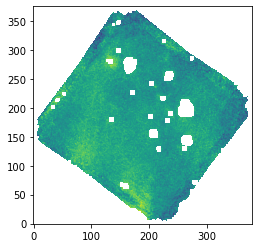

In [270]:
#create masked data for background model construction
data_ma2 = np.ma.masked_array(data, mask=mask_3sigma)

plt.imshow(data_ma2,origin='lower')
plt.show()

In [145]:
#create updated background model detected sources masked
bkg_data = Background2D(data_ma2,(bkgbox,bkgbox),bkg_estimator=bkg_estimator,edge_method='pad')
bkg_rms=bkg_data.background_rms 
bkg=bkg_data.background

#create background subtracted image
data_bkgsub = data - bkg

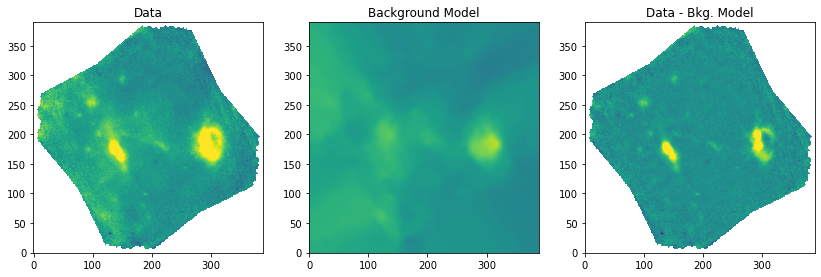

In [146]:
#plot the data and background model
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(14,10))
ax1.set_title('Data')

#set the image limits for the plots
minval=-0.1
maxval=0.1

ax1.imshow(data,origin='lower',vmin=minval,vmax=maxval)
ax2.set_title('Background Model')
ax2.imshow(bkg,origin='lower',vmin=minval,vmax=maxval)
ax3.set_title('Data - Bkg. Model')
ax3.imshow(data_bkgsub,origin='lower',vmin=minval,vmax=maxval)
plt.show()

In [122]:
#optional pad arrays - helps with edge sources but requires some care...
#ma=np.isnan(data_bkgsub)
#bkgsubstats=sigma_clipped_stats(data_bkgsub)
#data_bkgsub[ma]=bkgsubstats[1]

#ma=np.isnan(errormap)
#errormap[ma]=np.nanmax(errormap)

## Do Photometry - Combined source list

In [123]:
#load in source lists if they exist
if os.path.isfile(field.name+'_'+str(wavelength)+'um_CombinedSources.fits'):
    combTab=Table.read(field.name+'_'+str(wavelength)+'um_CombinedSources.fits')
else:
    combTab=None
    
#Get Source coordinates from table
if combTab is not None:
    sourcesAll=combTab['sky_centroid']

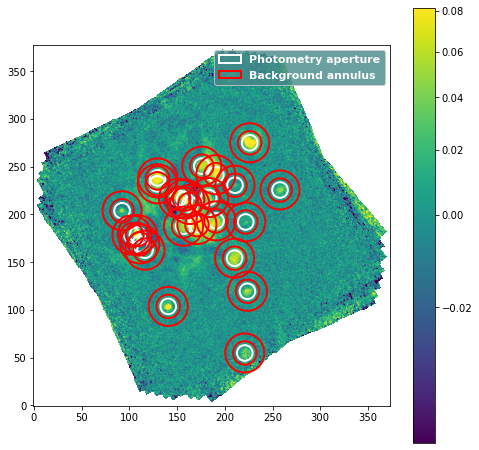

In [124]:
if combTab is not None:
    CombPhotTable=performApPhoto(data_bkgsub,errormap,tmap,header,sourcesAll,radii,r_in,r_out,plot=True)
    
    #add additonal information to table
    CombPhotTable['Field']=field.name
    CombPhotTable['wv']=wavelength

    #display the photometry table
    #CombPhotTable
else:
    print('No sources found in Combined Source List')

In [125]:
#merge Tables
mtComb = join(combTab, CombPhotTable, keys='id')

#add shape parameters to table - skip fitshapes because it is depreciated
#mtComb=fitshapes(data_bkgsub,mtComb) #,cutouts=True,cutsize=cutsize) #optional plot=True for diagnostic plots

mtComb=modelSources(data_bkgsub,errormap,mtComb,header,cutouts=True,cutsize=cutsize)

#show table - optional
mtComb

sky_centroid,finder,id,xcenter,ycenter,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fwhm,fwhm_err,elong,mfit_x0,mfit_y0,mfit_amp,mfit_gamma,mfit_gamma_err,mfit_alpha,mfit_alpha_err,gfit_x0,gfit_y0,gfit_x0_err,gfit_y0_err,gfit_amp,gfit_xfwhm,gfit_xfwhm_err,gfit_yfwhm,gfit_yfwhm_err,gfit_orient,FluxMoffat2D,FluxMoffatErr,mModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,MFitFlag,GFitFlag,"cutouts [25,25]","gresid [17,17]","mresid [17,17]",fit_dist,vexFlag,BestModel
"deg,deg",,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
object,int32,int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,int32,str1
"266.15958810631565,-29.4870540110217",4,1,140.79617897830911,103.65705672956474,"266.15958810631565,-29.4870540110217",4.118877948186719,0.07428289330910193,5.880415071127242,0.14852523587066851,6.689652517780692,0.22277743913639766,842.3888604858962,-0.0004360286918269784,-0.0010150604790490443,0.005534708537356831,384.61279296875,383.88961075160574,4.141834555239674,0.3361897931547803,74.63595017515914,52.64930378036851,5.972241499339064,0.502059008892302,53.809961870011776,210.59721512147405,6.89626198125729,0.6081031221405288,41.42359774501574,473.8437340233166,Field50,25,2.7394201427258484,0.5238950706150421,1.1076950527863725,7.715758065511477,7.638950359873494,0.2468050706446584,2.412146494224196,0.4613062590201884,1.5894004435076754,0.2109150094898349,7.69051021270542,7.635635588382319,0.048889945911148085,0.04176456553991325,0.2081137249162909,3.6305057538112475,0.03835900221896379,3.27753179422335,0.031263695974797764,3.4865894252484964,6.1775018326774385,0.4883935538764114,178.71284875140125,2.635257327371875,4.757147598333015,0.38104089055931084,109.29269735336604,4.690903597649397,0,0,0.0029550677578212454 .. 0.008739941344154855,0.001318199727631355 .. 0.0060678800648008725,-0.000597317718165295 .. 0.004569093174474204,0.47806417235884086,0,m
"266.1392604596048,-29.48368416628188",4,2,223.74012307808286,119.45644509510477,"266.1392604596048,-29.48368416628188",2.266589374343217,0.07409484594885447,4.244379281306372,0.14826544081757542,5.27153753691956,0.22243888246531238,842.3888604858962,0.00029229598014854537,0.0006733627134428786,0.005826426847044031,384.61279296875,384.27044123842836,2.251200194490596,0.19914825452129212,38.53557947294348,52.64930378036851,4.182822561895887,0.3760862075281756,35.800345888747955,210.59721512147405,5.133034918245968,0.4877716942461128,29.288743476117315,473.8437340233166,Field50,25,6.344439056248252,0.23974260374027997,1.4380425316128667,7.854520617954939,8.221792131308986,0.06396661802483061,7.155444963163955,45.402784409168646,2.9527465512473507,16.70328898457664,7.918627229630733,8.295219308180341,0.22288229480826088,0.16904988952640124,0.05937417047870767,7.608150508238619,0.2184316058206587,5.2906296865264055,0.09881371173464387,0.5919232702573948,4.528264604005018,0.3666105454800409,60.29935141729119,1.9421659188649925,4.4175427994104925,0.35994970815383415,52.418131117862956,1.5351463213593244,0,0,0.01016734296150416 .. 0.007665721043167385,0.010671516637008013 .. 0.006660378479864162,0.010324818393319442 .. 0.0066222959617077

In [126]:
#write out catalog - May want some additional pre-processing before we get here but go ahead and print for now...
mtComb.write(field.name+'_'+str(wavelength)+'um_CombCat.fits', overwrite=True)

## Testing for Model fitting 

In [17]:
#...

## Do Photometry - Only Segment Map Sources (optional)

In [18]:
#get seg table from detection step
if os.path.isfile(field.name+'_'+str(wavelength)+'um_seg.fits'):
    segTab=Table.read(field.name+'_'+str(wavelength)+'um_seg.fits')
else:
    segTab=None

#Get Source coordinates from table
if segTab is not None:
    sourcesseg=segTab['sky_centroid']

In [19]:
if segTab is not None:
    SegPhotTable=performApPhoto(data_bkgsub,tmap,wcsmap,sourcesseg,radii,r_in,r_out,plot=True)

    #display the photometry table
    #SegPhotTable
else:
    print('No sources found in segmentation map')

No sources found in segmentation map


In [20]:
#fix id keywords in Seg table so they can be merged
try:
    segTab.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

Do nothing because keyword is already changed.


In [21]:
#merge Tables
mtSeg = join(segTab, SegPhotTable, keys='id')

#add shape parameters to table
mtSeg=fitshapes(data_bkgsub,mtSeg) #optional plot=True for diagnostic plots

#display seg table
mtSeg

NameError: name 'SegPhotTable' is not defined

In [ ]:
#write out the resulting tables to file
mtSeg.write(field.name+'_'+str(wavelength)+'um_segCat.fits',overwrite=True)

## Do Photometry - Only DAO Sources (optional)

In [ ]:
if os.path.isfile(field.name+'_'+str(wavelength)+'um_dao.fits'):   
    daoTab=Table.read(field.name+'_'+str(wavelength)+'um_dao.fits')
else:
    daoTab=None
    
if daoTab is not None:
    sourcesdao=daoTab['sky_centroid']

In [ ]:
if daoTab is not None:
    DaoPhotTable=performApPhoto(data_bkgsub,tmap,wcsmap,sourcesdao,radii,r_in,r_out,plot=True)

    #display the photometry table
    #DaoPhotTable
else:
    print('No sources found by DAOfind map')

In [ ]:
#merge Tables
mtDao = join(daoTab, DaoPhotTable, keys='id')

#add shape parameters to table
mtDao=fitshapes(data_bkgsub,mtDao) #optional plot=True for diagnostic plots

#optional - show Dao table
#mtDao

In [ ]:
#write out the resulting tables to file
mtDao.write(field.name+'_'+str(wavelength)+'um_daoCat.fits',overwrite=True)